In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate
import scipy.interpolate
import matplotlib.pyplot as plt

import shared_functions_setup as setup

SURVEY = 'SDSS'

if (SURVEY=='SDSS'):
    import params as pa
elif (SURVEY=='LSST_DESI'):
    import params_LSST_DESI as pa
else:
    print "We don't have support for that survey yet; exiting."
    exit()

In [2]:
def sigma_e(z_s_):
    """ Returns a value for the model for the per-galaxy noise as a function of source redshift"""

    if (SURVEY=='SDSS'):

        if hasattr(z_s_, "__len__"):
            sig_e = 2. / pa.S_to_N * np.ones(len(z_s_))
        else:
            sig_e = 2. / pa.S_to_N

    elif(SURVEY=='LSST_DESI'):
        #print "THE SIGMA_E VALUES WE ARE USING HERE NEED TO BE FIXED."
        if hasattr(z_s_, "__len__"):
            sig_e = pa.a_sm / pa.SN_med * ( 1. + (pa.b_sm / pa.R_med)**pa.c_sm) * np.ones(len(z_s_))
        else:
            sig_e = pa.a_sm / pa.SN_med * ( 1. + (pa.b_sm / pa.R_med)**pa.c_sm) 

    return sig_e

def get_SigmaC_inv(z_s_, z_l_):
    """ Returns the theoretical value of 1/Sigma_c, (Sigma_c = the critcial surface mass density).
    z_s_ and z_l_ can be 1d arrays, so the returned value will in general be a 2d array. """

    com_s = chi_of_z(z_s_) 
    com_l = chi_of_z(z_l_) 

    # Get scale factors for converting between angular-diameter and comoving distances.
    a_l = 1. / (z_l_ + 1.)
    a_s = 1. / (z_s_ + 1.)
    
    D_s = a_s * com_s # Angular diameter source distance.
    D_l = a_l * com_l # Angular diameter lens distance
    
    # The dimensions of D_ls depend on the dimensions of z_s_ and z_l_
    if ((hasattr(z_s_, "__len__")==True) and (hasattr(z_l_, "__len__")==True)):
        D_ls = np.zeros((len(z_s_), len(z_l_)))
        Sigma_c_inv = np.zeros((len(z_s_), len(z_l_)))
        for zsi in range(0,len(z_s_)):
            for zli in range(0,len(z_l_)):
                D_ls[zsi, zli] = D_s[zsi] - D_l[zli]
                # Units are pc^2 / (h Msun), comoving
                if(D_ls[zsi, zli]<0.):
                    Sigma_c_inv[zsi, zli] = 0.
                else:
                    Sigma_c_inv[zsi, zli] = 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l[zli] * D_ls[zsi, zli] * (1 + z_l_[zli])**2 / D_s[zsi]
    else:
        D_ls = (D_s - D_l) 
        # Units are pc^2 / (h Msun), comoving
        if hasattr(z_s_, "__len__"):
            Sigma_c_inv = np.zeros(len(z_s_))
            for zsi in range(0, len(z_s_)):
                if(D_s[zsi]<=D_l):
                    Sigma_c_inv[zsi] = 0.
                else:
                    Sigma_c_inv[zsi] = 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l * D_ls[zsi]* (1 + z_l_)**2 / D_s[zsi]
        elif hasattr(z_l_, "__len__"): 
            Sigma_c_inv = np.zeros(len(z_l_))
            for zli in range(0,len(z_l_)):
                if(D_s<=D_l[zli]):
                    Sigma_c_inv[zli] = 0.
                else:
                    Sigma_c_inv[zli] = 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l[zli] * D_ls[zli]* (1 + z_l_[zli])**2 / D_s
        else:
            if (D_s<D_l):
                Sigma_c_inv=0.
            else:
                 Sigma_c_inv= 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l * D_ls* (1 + z_l_)**2 / D_s
                    
    return Sigma_c_inv


def weights(e_rms, z_, z_l_):

    """ Returns the inverse variance weights as a function of redshift. """
        
    SigC_t_inv = get_SigmaC_inv(z_, z_l_)

    if ((hasattr(z_, "__len__")==True) and (hasattr(z_l_, "__len__")==True)):
        weights = np.zeros((len(z_), len(z_l_)))
        for zsi in range(0,len(z_)):
            for zli in range(0,len(z_l_)):
                weights[zsi, zli] = SigC_t_inv[zsi, zli]**2/(sigma_e(z_)[zsi]**2 + e_rms**2)
    else:
        if (hasattr(z_, "__len__")):
            weights = SigC_t_inv**2/(sigma_e(z_)**2 + e_rms**2 * np.ones(len(z_)))
        else:
            weights = SigC_t_inv**2/(sigma_e(z_)**2 + e_rms**2 )

    return weights

def weights_shapes(e_rms, z_):
    """ Returns the inverse variance weights as a function of redshift for tangential shear (not DS). """

    weights = 1./(sigma_e(z_)**2 + e_rms**2 * np.ones(len(z_)))

    return weights

def get_NofZ_unnormed(dNdzpar, dNdztype, z):
    """ Returns the dNdz of the sources as a function of photometric redshift, as well as the z points at which it is evaluated."""

    if (dNdztype == 'Nakajima'):
        # dNdz takes form like in Nakajima et al. 2011 equation 3
        a = dNdzpar[0]
        zs = dNdzpar[1]

        nofz_ = (z / zs)**(a-1.) * np.exp( -0.5 * (z / zs)**2)
    elif (dNdztype == 'Smail'):
        # dNdz take form like in Smail et al. 1994
        alpha = dNdzpar[0]
        z0 = dNdzpar[1]
        beta = dNdzpar[2]
        nofz_ = z**alpha * np.exp( - (z / z0)**beta)
    else:
        print "dNdz type "+str(dNdztype)+" not yet supported; exiting."
        exit()

    return  nofz_

In [3]:
# Set up interpolating functions for z(chi) and chi(z)
(z_of_chi, chi_of_z) = setup.z_interpof_com(SURVEY)

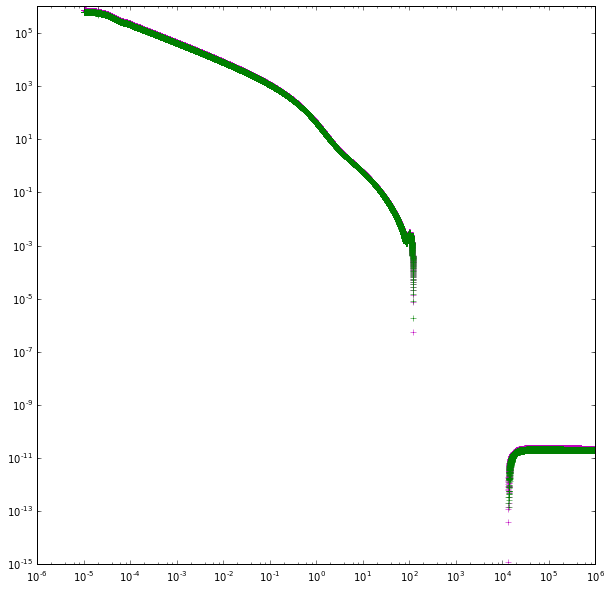

In [4]:
rp_fix = 1.0
zLvec = np.linspace(pa.zLmin, pa.zLmax, 100)

# Import the correlation function, from CLASS w/ halofit + FFTlog
xi_2h = np.zeros((40000, len(zLvec)))
for zi in range(0,len(zLvec)):
    stringz = str(zLvec[zi]) #'{:.8f}'.format(zLvec[zi])
    (r, xi_2h[:, zi]) = np.loadtxt('./txtfiles/xi_z='+stringz+'.txt', unpack=True)
    xi = pa.bd* pa.bs * xi_2h
    
plt.figure(figsize=[10,10])
plt.loglog(r, xi[:, 0], 'm+')
plt.hold(True)
plt.loglog(r, xi[:, 15], 'g+')
plt.show()


In [5]:
# Get the comoving distance associated to the lens redshift
chi_vec = setup.com(zLvec, SURVEY)

# Figure out the min and max value of the * positive * part of the vector of projected distances
if (min(r)>rp_fix):
    minPiPos = np.sqrt(min(r)**2 - rp_fix**2)
else:
    minPiPos = 0.

maxPiPos=np.zeros(len(zLvec))
Pi_pos=[0]*len(zLvec)
for zi in range(0,len(zLvec)):
    maxPiPos[zi] = chi_of_z(pa.zsmax) - chi_vec[zi]
    Pi_pos[zi] = scipy.linspace(minPiPos, maxPiPos[zi], 500)
    
# Pi can be positive or negative, so now flip this and include the negative values, but only down to z=0
# And avoid including multiple of the same values - this messes up some integration routines.
Pi = [0]*len(zLvec)
for zi in range(0, len(zLvec)):
    Pi_pos_vec= list(Pi_pos[zi])[1:]
    Pi_pos_vec.reverse()
    index_cut = next(j[0] for j in enumerate(Pi_pos_vec) if j[1]<=(chi_vec[zi]-chi_of_z(pa.zsmin)))
    Pi[zi] = np.append(-np.asarray(Pi_pos_vec[index_cut:]), Pi_pos[zi])

# Get the correlation function in terms of Pi at a variety of rp values, including rp=1 where we want it for using the power law
#rpvec = np.logspace(np.log10(0.05), np.log10(20.), 30)
#xi_interp_r = [0] * len(zLvec)
#xi_ofPi = [0] * len(zLvec)
#for zi in range(0,len(zLvec)):
#    print "z=", zi
#    xi_interp_r[zi] = scipy.interpolate.interp1d(r, xi[:, zi])
#    xi_ofPi[zi] = np.zeros((len(rpvec), len(Pi[zi])))
#    for ri in range(0,len(rpvec)):
#        for pi in range(0,len(Pi[zi])):
#            xi_ofPi[zi][ri, pi] = xi_interp_r[zi](np.sqrt(rpvec[ri]**2 + Pi[zi][pi]**2))

# Get the correlation function in terms of Pi at rp=1 where we want it for using the power law
xi_interp_r = [0] * len(zLvec)
xi_ofPi = [0] * len(zLvec)
for zi in range(0,len(zLvec)):
    xi_interp_r[zi] = scipy.interpolate.interp1d(r, xi[:, zi])
    xi_ofPi[zi] = np.zeros(len(Pi[zi]))
    for pi in range(0,len(Pi[zi])):
        xi_ofPi[zi][pi] = xi_interp_r[zi](np.sqrt(rp_fix**2 + Pi[zi][pi]**2))
    
# Get the vector of com dist values associated to Pi values:
com_Pi = [0]*len(zLvec)
z_Pi = [0]*len(zLvec)
for zi in range(0,len(zLvec)):
    com_Pi[zi] = chi_vec[zi] + Pi[zi]
    z_Pi[zi] = z_of_chi(com_Pi[zi])

# Now we effectively have xi_{ls}(rp=1, Pi(z_s); z_L)

In [6]:
# Okay, now we do the required integrals:
# Define the z_ph vectors for the three subsamples we care about:
lenzph = 500
z_a = [0]*len(zLvec); z_b = [0]* len(zLvec); z_asc = [0] * len(zLvec)
for zi in range(0,len(zLvec)):
    z_a[zi] = scipy.linspace(zLvec[zi], zLvec[zi] +pa.delta_z, lenzph)
    z_b[zi] = scipy.linspace(zLvec[zi]+pa.delta_z, pa.zphmax, lenzph)
    # For the "assoc" sample we need to get the z-edges
    if (pa.close_cut<chi_vec[zi]):
        zasc_min = z_of_chi(chi_vec[zi] - pa.close_cut)
        zasc_max = z_of_chi(chi_vec[zi] + pa.close_cut)
    else:
        zasc_min = 0.
        zasc_max = z_of_chi(chi_vec[zi] + pa.close_cut)
    z_asc[zi] = scipy.linspace(zasc_min, zasc_max, lenzph)

# Get dNdz
dNdz = [0] * len(zLvec)
for zi in range(0, len(zLvec)):
    dNdz[zi] = get_NofZ_unnormed(pa.dNdzpar_fid, pa.dNdztype, z_Pi[zi])

# Do the integrals in spec-z
#specint_num_a = np.zeros(((lenzph), len(zLvec), len(rpvec))); specint_num_b = np.zeros(((lenzph), len(zLvec), len(rpvec))); specint_num_asc = np.zeros(((lenzph), len(zLvec), len(rpvec)))
specint_num_a = np.zeros(((lenzph), len(zLvec))); specint_num_b = np.zeros(((lenzph), len(zLvec))); specint_num_asc = np.zeros(((lenzph), len(zLvec)))
specint_denom_a = np.zeros(((lenzph), len(zLvec))); specint_denom_b = np.zeros(((lenzph), len(zLvec))); specint_denom_asc = np.zeros(((lenzph), len(zLvec)))
for j in range(0,len(zLvec)):
    print "zl=", j
    for i in range(0, lenzph):
        #for ri in range(0, len(rpvec)):
        
        #specint_num_a[i,j, ri] = scipy.integrate.simps(dNdz[j] * p_z(z_a[j][i], z_Pi[j], pzpar, pztype) * xi_ofPi[j][ri, :], z_Pi[j])
        #specint_num_b[i,j, ri] = scipy.integrate.simps(dNdz[j] * p_z(z_b[j][i], z_Pi[j], pzpar, pztype) * xi_ofPi[j][ri, :], z_Pi[j])
        #specint_num_asc[i,j,ri] = scipy.integrate.simps(dNdz[j] * p_z(z_asc[j][i], z_Pi[j], pzpar, pztype) * xi_ofPi[j][ri, :], z_Pi[j])

        specint_num_a[i,j] = scipy.integrate.simps(dNdz[j] * setup.p_z(z_a[j][i], z_Pi[j], pa.pzpar_fid, pa.pztype) * xi_ofPi[j], z_Pi[j])
        specint_num_b[i,j] = scipy.integrate.simps(dNdz[j] * setup.p_z(z_b[j][i], z_Pi[j], pa.pzpar_fid, pa.pztype) * xi_ofPi[j], z_Pi[j])
        specint_num_asc[i,j] = scipy.integrate.simps(dNdz[j] * setup.p_z(z_asc[j][i], z_Pi[j], pa.pzpar_fid, pa.pztype) * xi_ofPi[j], z_Pi[j])

            
for j in range(0,len(zLvec)):
    for i in range(0,lenzph):
        specint_denom_a[i,j] = scipy.integrate.simps(dNdz[j] * setup.p_z(z_a[j][i], z_Pi[j], pa.pzpar_fid, pa.pztype), z_Pi[j])
        specint_denom_b[i,j] = scipy.integrate.simps(dNdz[j] * setup.p_z(z_b[j][i], z_Pi[j], pa.pzpar_fid, pa.pztype), z_Pi[j])
        specint_denom_asc[i,j] = scipy.integrate.simps(dNdz[j] * setup.p_z(z_asc[j][i], z_Pi[j], pa.pzpar_fid, pa.pztype), z_Pi[j])
    
# Now do the integrals in photo-z
w_a = [0]*len(zLvec); w_b = [0]*len(zLvec); w_asc = [0]*len(zLvec)
for zi in range(0,len(zLvec)):
    w_a[zi] = weights(pa.e_rms_Bl_a,z_a[zi], zLvec)
    w_b[zi] = weights(pa.e_rms_Bl_b,z_b[zi], zLvec)
    w_asc[zi] = weights_shapes(pa.e_rms_a,z_asc[zi])

#B_1_a = np.zeros((len(zLvec), len(rpvec)))
#B_1_b = np.zeros((len(zLvec), len(rpvec)))
#B_1_asc = np.zeros((len(zLvec), len(rpvec)))
B_1_a = np.zeros((len(zLvec)))
B_1_b = np.zeros((len(zLvec)))
B_1_asc = np.zeros((len(zLvec)))
for zi in range(0,len(zLvec)):
    #    for ri in range(0,len(rpvec)):
    #        B_1_a[zi,ri]= scipy.integrate.simps(w_a[zi][:, zi] * specint_num_a[:, zi, ri], z_a[zi]) / scipy.integrate.simps(w_a[zi][:, zi]* specint_denom_a[:, zi], z_a[zi])
    #        B_1_b[zi,ri] = scipy.integrate.simps(w_b[zi][:, zi] * specint_num_b[:, zi, ri], z_b[zi]) / scipy.integrate.simps(w_b[zi][:, zi]* specint_denom_b[:, zi], z_b[zi])
    #        B_1_asc[zi,ri] = scipy.integrate.simps(w_asc[zi]*specint_num_asc[:, zi, ri], z_asc[zi]) / scipy.integrate.simps(w_asc[zi]* specint_denom_asc[:,zi], z_asc[zi])
    B_1_a[zi]= scipy.integrate.simps(w_a[zi][:, zi] * specint_num_a[:, zi], z_a[zi]) / scipy.integrate.simps(w_a[zi][:, zi]* specint_denom_a[:, zi], z_a[zi])
    B_1_b[zi] = scipy.integrate.simps(w_b[zi][:, zi] * specint_num_b[:, zi], z_b[zi]) / scipy.integrate.simps(w_b[zi][:, zi]* specint_denom_b[:, zi], z_b[zi])
    B_1_asc[zi] = scipy.integrate.simps(w_asc[zi]*specint_num_asc[:, zi], z_asc[zi]) / scipy.integrate.simps(w_asc[zi]* specint_denom_asc[:,zi], z_asc[zi])

    
    
    
# Now integrate these over zl
dndzl = setup.get_dNdzL(zLvec, SURVEY)

Boost_a = scipy.integrate.simps(B_1_a * dndzl, zLvec)
Boost_b = scipy.integrate.simps(B_1_b * dndzl, zLvec)
Boost_asc = scipy.integrate.simps(B_1_asc *dndzl, zLvec)

print "boost - 1, sample a=", Boost_a
print "boost -1, sample b=", Boost_b
print "boost -1, sample asc=", Boost_asc

#Boost_a = np.zeros(len(rpvec))
#Boost_b = np.zeros(len(rpvec))
#Boost_asc = np.zeros(len(rpvec))

#for ri in range(0,len(rpvec)):
#    Boost_a[ri] = scipy.integrate.simps(B_1_a[:, ri], zLvec)
#    Boost_b[ri] = scipy.integrate.simps(B_1_b[:,ri], zLvec)
#    Boost_asc[ri]= scipy.integrate.simps(B_1_asc[:, ri], zLvec)
    
#Boost_a_interp= scipy.interpolate.interp1d(rpvec, Boost_a)
#Boost_b_interp = scipy.interpolate.interp1d(rpvec, Boost_b)
#Boost_asc_interp = scipy.interpolate.interp1d(rpvec, Boost_asc)

#plt.figure()
#plt.loglog(rpvec, Boost_a, 'go')
#plt.hold(True)
#plt.loglog(rpvec,  Boost_a_interp(1.) * rpvec**(-0.8), 'mo')
#plt.show()

#plt.figure()
#plt.loglog(rpvec, Boost_b, 'go')
#plt.hold(True)
#plt.loglog(rpvec,  Boost_b_interp(1.) * rpvec**(-0.8), 'mo')
#plt.show()


#plt.figure()
#plt.loglog(rpvec, Boost_asc, 'go')
#plt.hold(True)
#plt.loglog(rpvec,  Boost_asc_interp(1.) * rpvec**(-0.8), 'mo')
#plt.show()



#print "Boost-1, sample a=", Boost_a_interp(1.)
#print "Boost-1, sample b =", Boost_b_interp(1.)
#print "Boost-1, sample assoc =", Boost_asc_interp(1.)
    

zl= 0
zl= 1
zl= 2
zl= 3
zl= 4
zl= 5
zl= 6
zl= 7
zl= 8
zl= 9
zl= 10
zl= 11
zl= 12
zl= 13
zl= 14
zl= 15
zl= 16
zl= 17
zl= 18
zl= 19
zl= 20
zl= 21
zl= 22
zl= 23
zl= 24
zl= 25
zl= 26
zl= 27
zl= 28
zl= 29
zl= 30
zl= 31
zl= 32
zl= 33
zl= 34
zl= 35
zl= 36
zl= 37
zl= 38
zl= 39
zl= 40
zl= 41
zl= 42
zl= 43
zl= 44
zl= 45
zl= 46
zl= 47
zl= 48
zl= 49
zl= 50
zl= 51
zl= 52
zl= 53
zl= 54
zl= 55
zl= 56
zl= 57
zl= 58
zl= 59
zl= 60
zl= 61
zl= 62
zl= 63
zl= 64
zl= 65
zl= 66
zl= 67
zl= 68
zl= 69
zl= 70
zl= 71
zl= 72
zl= 73
zl= 74
zl= 75
zl= 76
zl= 77
zl= 78
zl= 79
zl= 80
zl= 81
zl= 82
zl= 83
zl= 84
zl= 85
zl= 86
zl= 87
zl= 88
zl= 89
zl= 90
zl= 91
zl= 92
zl= 93
zl= 94
zl= 95
zl= 96
zl= 97
zl= 98
zl= 99
boost - 1, sample a= 0.266633544767
boost -1, sample b= 0.0380009438088
boost -1, sample asc= 0.418066525004
